**Description**:

This notebook focuses on implementing K-Means clustering using data reduced by PCA, TSNE, and UMAP techniques. It involves extensive exploratory analysis to evaluate different numbers of clusters, metrics, and feature selections to ensure robust clustering before transitioning to supervised learning. The primary focus is on utilizing only demographic attributes to train the clustering models for predicting tone preferences.

## Imports

In [265]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Non-Hierarchical Clustering Models
from sklearn.cluster import KMeans
import umap
from sklearn.manifold import TSNE

# Metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# encoder
from sklearn.preprocessing import OrdinalEncoder

# classification
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


In [266]:
%pip install kmodes scikit-learn-extra 


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [267]:
path = '../datasets/FoodInsecurity_Hispanic_Demographics_Tone_Preferences_Dataset.xlsx'

In [268]:
df = pd.read_excel(path)

In [269]:
df.columns

Index(['age', 'gender', 'ethnicity', 'race', 'education', 'marital_status',
       'income', 'employment', 'language', 'disability', 'states', 'sample_1',
       'sample_2', 'sample_3', 'sample_4', 'sample_5', 'sample_6', 'sample_7',
       'sample_8'],
      dtype='object')

In [270]:
df.head(2)

,age,gender,ethnicity,race,education,marital_status,income,employment,language,disability,states,sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8
0,45-54,female,non hispanic,native american,High School,na,"$25,000 - $49,999",Employed Part time,both,i do not have a disability,indiana,Persuasive,Simplier,Empathetic,Persuasive,Original,Original,Persuasive,Original
1,18-24,male,hispanic,white,High School,single,"Less than $25,000",Employed Part time,english,i do not have a disability,illinois,Original,Simplier,Empathetic,Simplier,Simplier,Original,Original,Persuasive


In [271]:
df.shape

(50, 19)

In [272]:
demographics = df[['age', 'marital_status', 'employment']]

In [273]:
demographics.head(2)

,age,marital_status,employment
0,45-54,na,Employed Part time
1,18-24,single,Employed Part time


In [274]:
df = pd.DataFrame(df)

# Melt the DataFrame to focus on tone samples
melted_df = pd.melt(df, id_vars=['age', 'gender', 'ethnicity', 'race', 'education',
                                 'marital_status', 'income', 'employment', 'language',
                                 'disability', 'states'],
                     value_vars=['sample_1', 'sample_2', 'sample_3', 'sample_4',
                                 'sample_5', 'sample_6', 'sample_7', 'sample_8'],
                     var_name='tone_sample',
                     value_name='tone')

In [275]:
tones = melted_df[['tone']]

In [276]:
tones.head(2)

,tone
0,Persuasive
1,Original


In [277]:
tones_encoded = pd.get_dummies(tones)

## Pre-processing

### Encoding

In [278]:
encoder = OrdinalEncoder()

In [279]:
demographics['age'] = encoder.fit_transform(demographics[['age']])

In [280]:
demographics.head(2)

,age,marital_status,employment
0,3.0,na,Employed Part time
1,0.0,single,Employed Part time


In [281]:
demographics_encoded = pd.get_dummies(demographics)

In [282]:
demographics_encoded.shape
#reduced from 19 to 13 by encoding the ordinal data

(50, 13)

### Scaling Data

In [283]:
scaler = StandardScaler()
demographics_scaled = scaler.fit_transform(demographics_encoded)

In [284]:
demographics_encoded.to_excel('../datasets/demographics_encoded.xlsx', index=False)


## PCA

In [285]:
pca = PCA(n_components=2)
demographics_pca = pca.fit_transform(demographics_scaled)

# Access the principal components
principal_components = pca.components_

# Access the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

### Elbow Method

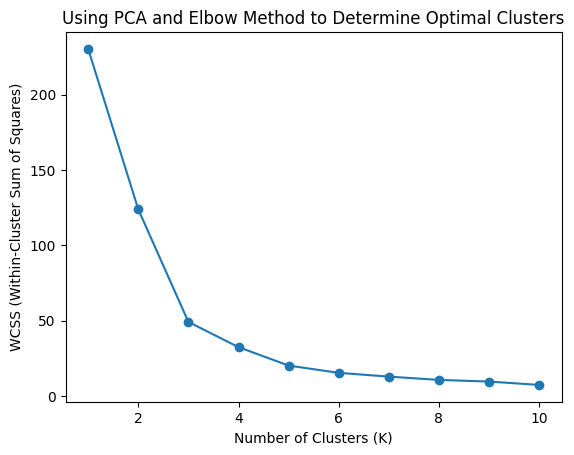

In [286]:
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(demographics_pca)
    wcss.append(kmeans.inertia_)  # Inertia is the WCSS

# Plotting the elbow curve
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Using PCA and Elbow Method to Determine Optimal Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.show()

### Metrics

For n_clusters = 2, the average silhouette score is: 0.49
For n_clusters = 2, the Calinski-Harabasz index is: 41.28
For n_clusters = 2, the Davies-Bouldin score is: 0.87


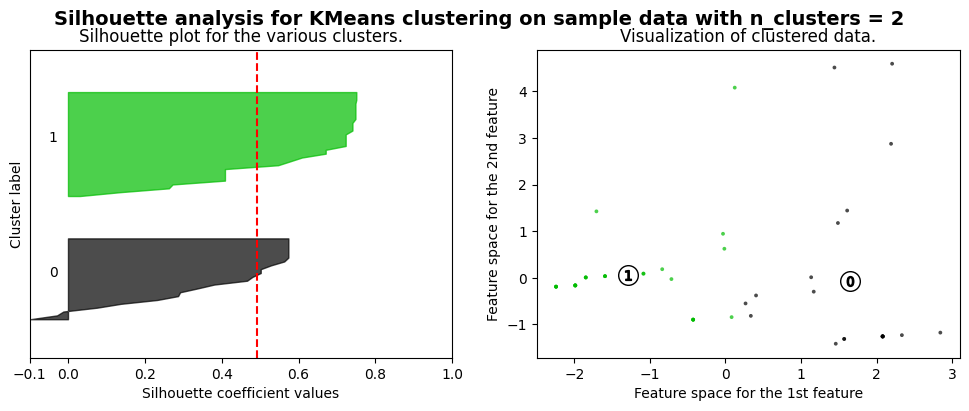

For n_clusters = 3, the average silhouette score is: 0.58
For n_clusters = 3, the Calinski-Harabasz index is: 86.56
For n_clusters = 3, the Davies-Bouldin score is: 0.54


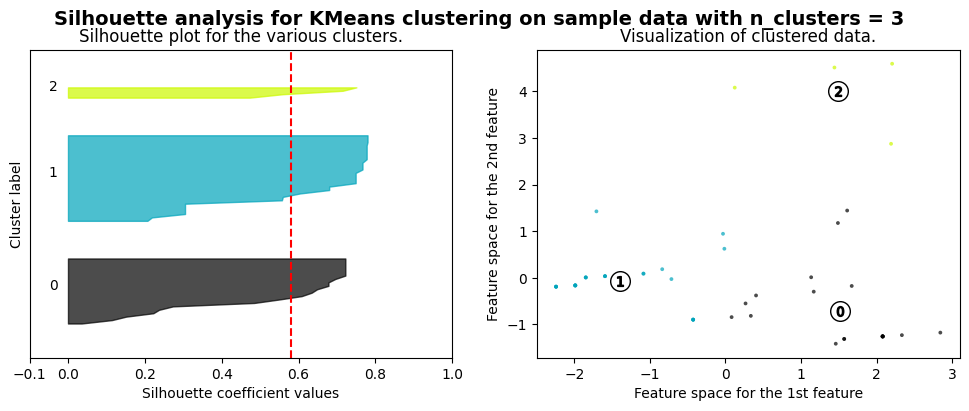

For n_clusters = 4, the average silhouette score is: 0.55
For n_clusters = 4, the Calinski-Harabasz index is: 93.46
For n_clusters = 4, the Davies-Bouldin score is: 0.65


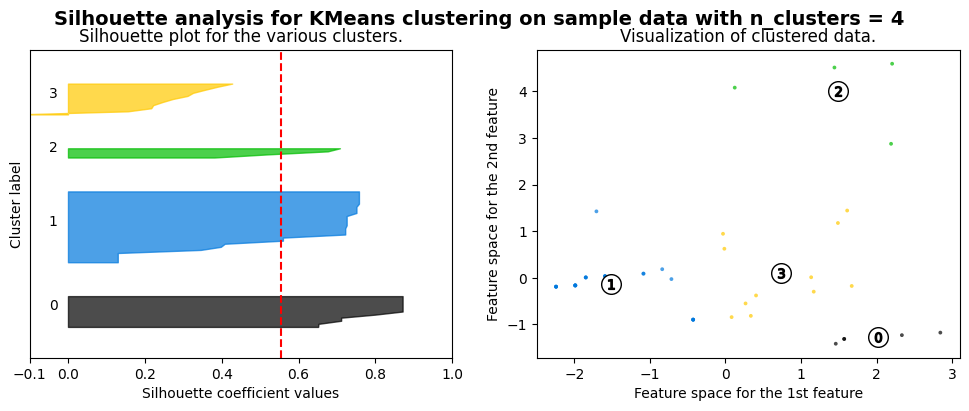

For n_clusters = 5, the average silhouette score is: 0.59
For n_clusters = 5, the Calinski-Harabasz index is: 116.82
For n_clusters = 5, the Davies-Bouldin score is: 0.66


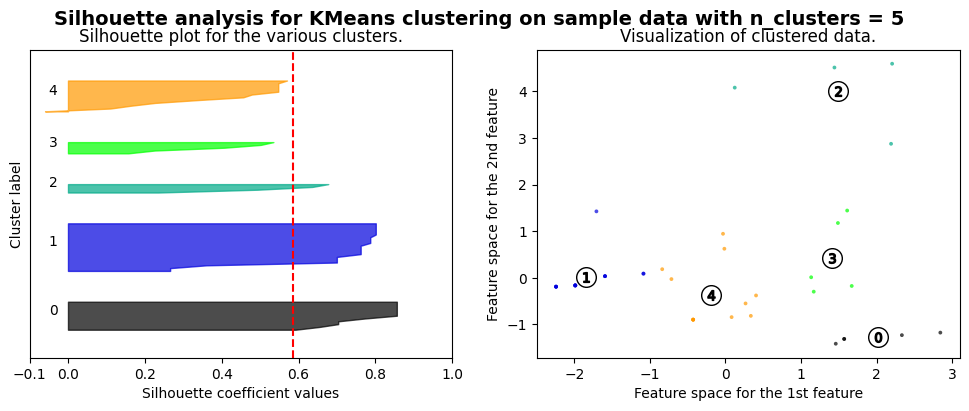

For n_clusters = 6, the average silhouette score is: 0.62
For n_clusters = 6, the Calinski-Harabasz index is: 122.80
For n_clusters = 6, the Davies-Bouldin score is: 0.65


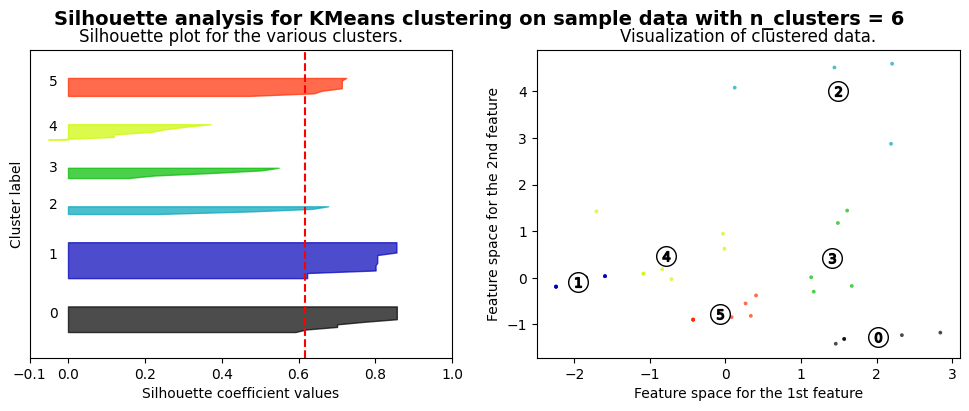

For n_clusters = 7, the average silhouette score is: 0.59
For n_clusters = 7, the Calinski-Harabasz index is: 120.76
For n_clusters = 7, the Davies-Bouldin score is: 0.62


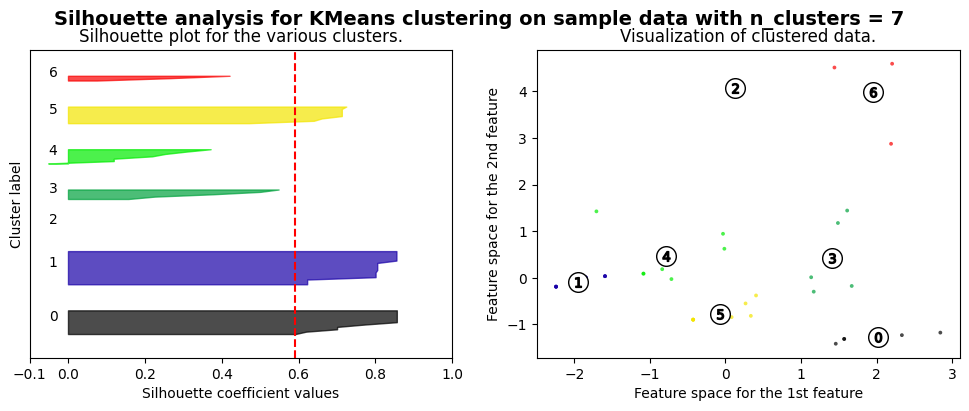

For n_clusters = 8, the average silhouette score is: 0.59
For n_clusters = 8, the Calinski-Harabasz index is: 122.90
For n_clusters = 8, the Davies-Bouldin score is: 0.50


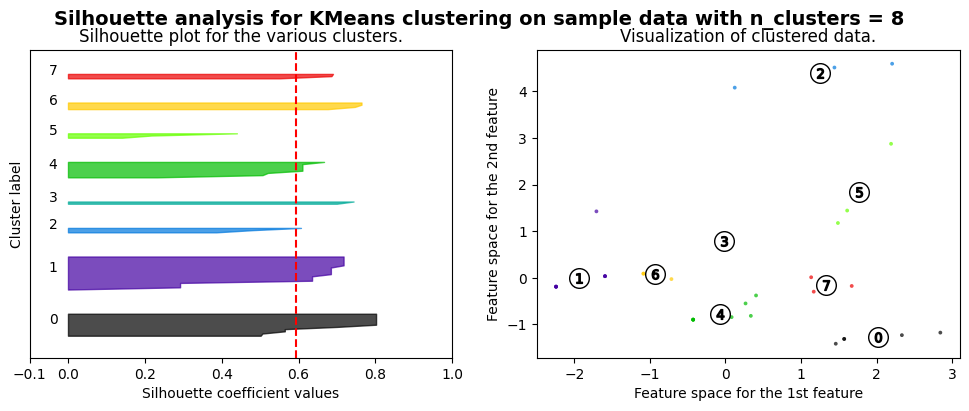

For n_clusters = 9, the average silhouette score is: 0.62
For n_clusters = 9, the Calinski-Harabasz index is: 117.62
For n_clusters = 9, the Davies-Bouldin score is: 0.47


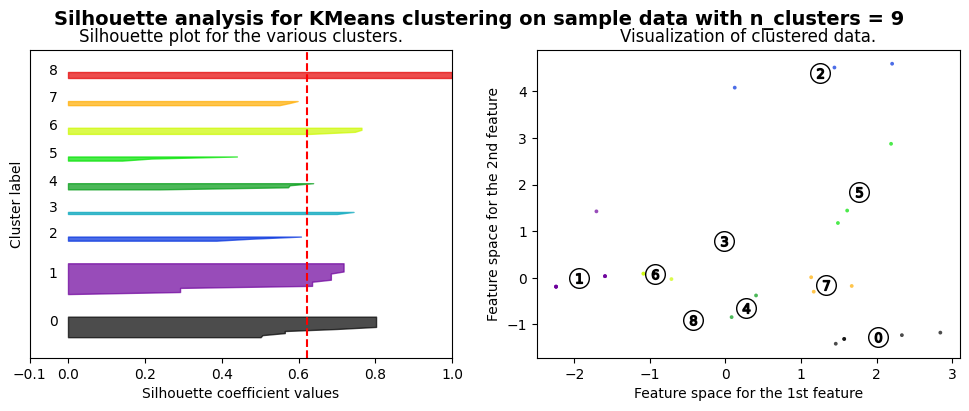

For n_clusters = 10, the average silhouette score is: 0.65
For n_clusters = 10, the Calinski-Harabasz index is: 134.09
For n_clusters = 10, the Davies-Bouldin score is: 0.42


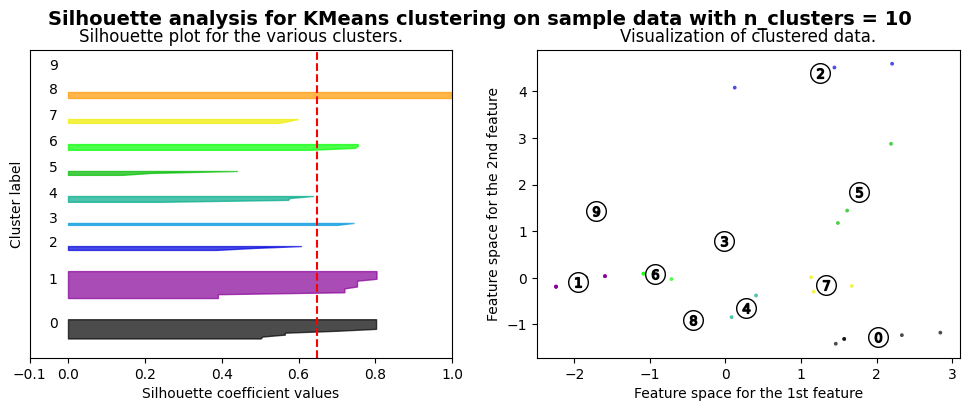

For n_clusters = 11, the average silhouette score is: 0.65
For n_clusters = 11, the Calinski-Harabasz index is: 160.03
For n_clusters = 11, the Davies-Bouldin score is: 0.36


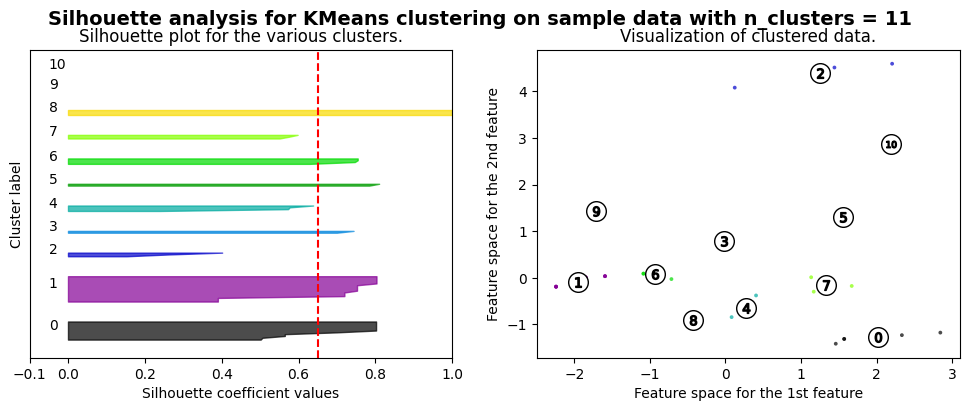

For n_clusters = 12, the average silhouette score is: 0.65
For n_clusters = 12, the Calinski-Harabasz index is: 230.40
For n_clusters = 12, the Davies-Bouldin score is: 0.30


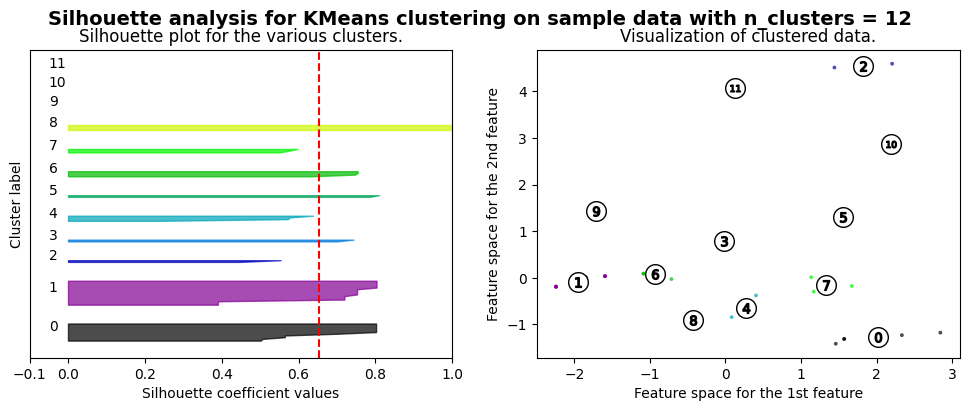

For n_clusters = 13, the average silhouette score is: 0.63
For n_clusters = 13, the Calinski-Harabasz index is: 225.43
For n_clusters = 13, the Davies-Bouldin score is: 0.25


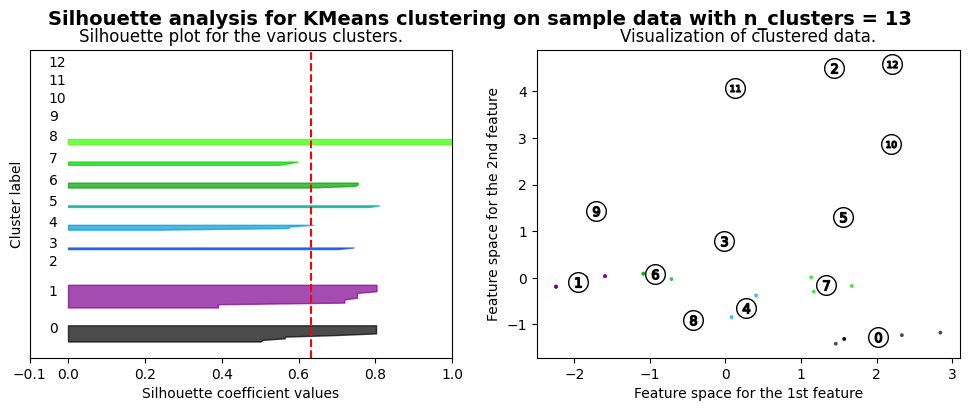

For n_clusters = 14, the average silhouette score is: 0.64
For n_clusters = 14, the Calinski-Harabasz index is: 301.51
For n_clusters = 14, the Davies-Bouldin score is: 0.26


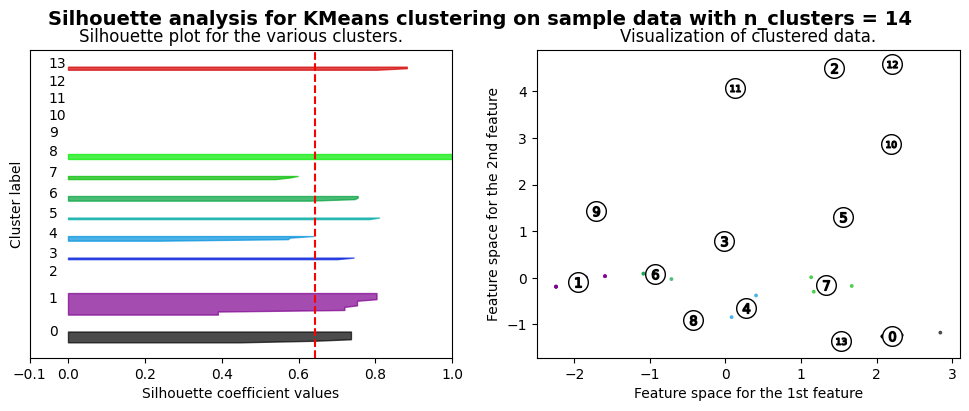

For n_clusters = 15, the average silhouette score is: 0.65
For n_clusters = 15, the Calinski-Harabasz index is: 351.09
For n_clusters = 15, the Davies-Bouldin score is: 0.23


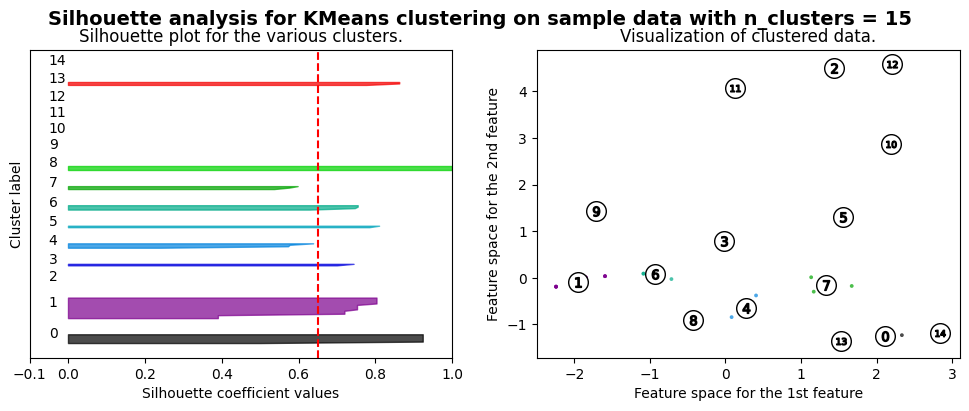

For n_clusters = 16, the average silhouette score is: 0.61
For n_clusters = 16, the Calinski-Harabasz index is: 476.00
For n_clusters = 16, the Davies-Bouldin score is: 0.23


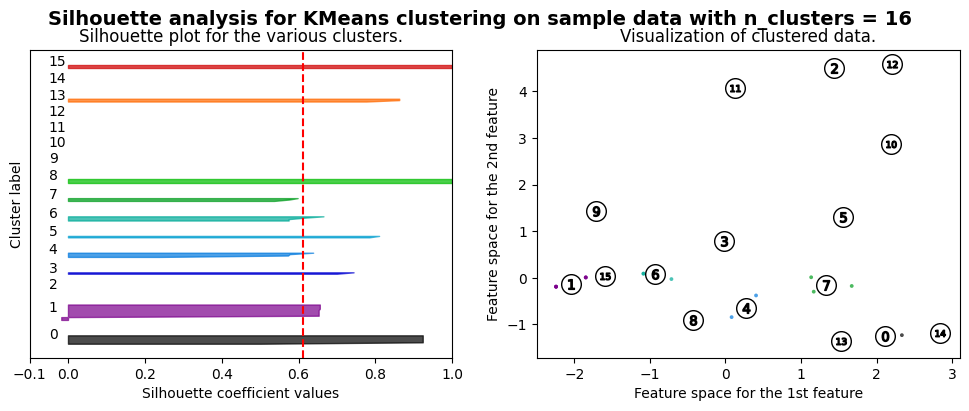

For n_clusters = 17, the average silhouette score is: 0.61
For n_clusters = 17, the Calinski-Harabasz index is: 456.71
For n_clusters = 17, the Davies-Bouldin score is: 0.22


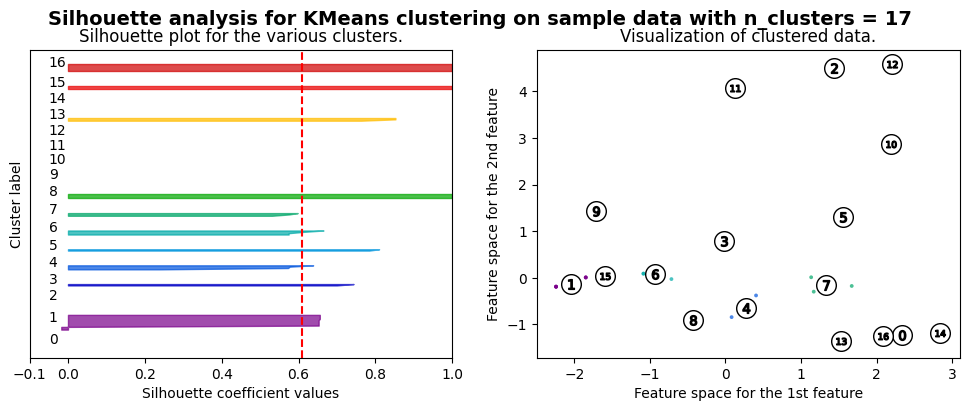

For n_clusters = 18, the average silhouette score is: 0.61
For n_clusters = 18, the Calinski-Harabasz index is: 459.44
For n_clusters = 18, the Davies-Bouldin score is: 0.24


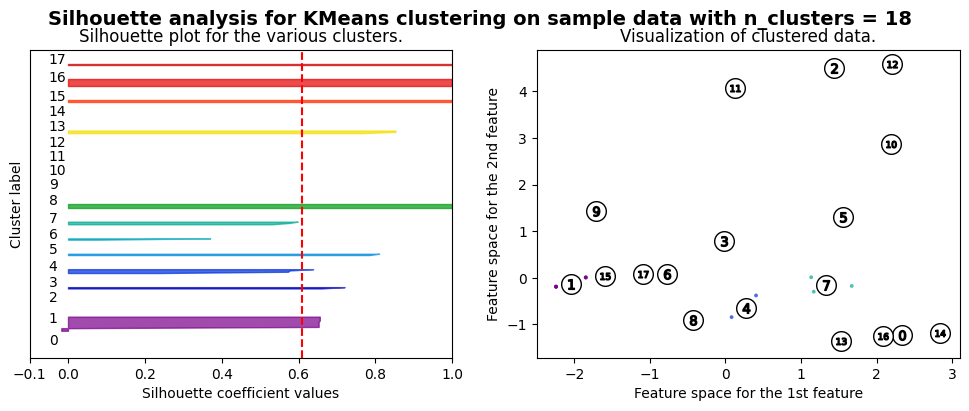

For n_clusters = 19, the average silhouette score is: 0.59
For n_clusters = 19, the Calinski-Harabasz index is: 520.80
For n_clusters = 19, the Davies-Bouldin score is: 0.21


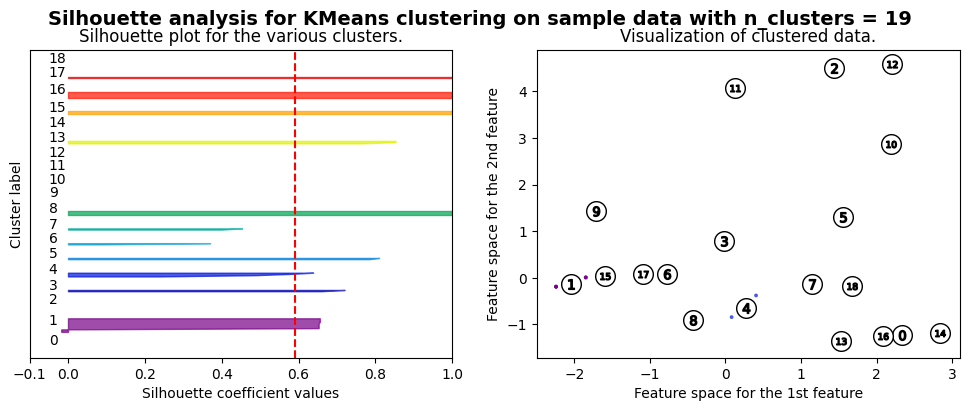

For n_clusters = 20, the average silhouette score is: 0.58
For n_clusters = 20, the Calinski-Harabasz index is: 595.13
For n_clusters = 20, the Davies-Bouldin score is: 0.24


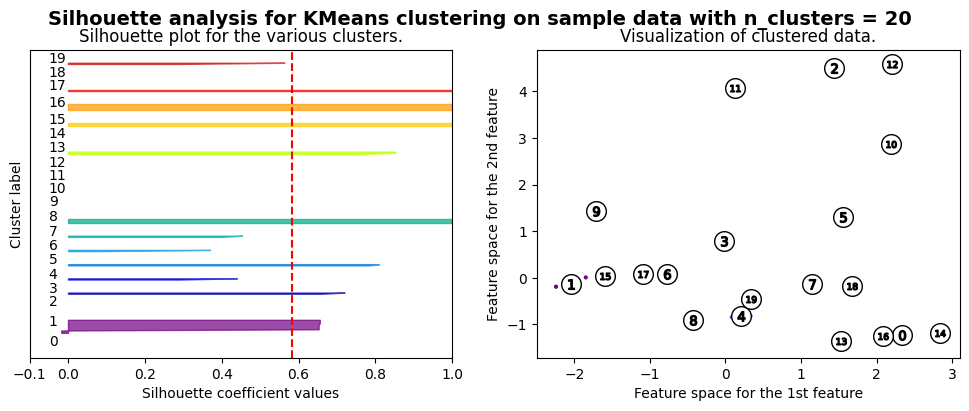

In [287]:
range_n_clusters = [2, 3, 4, 5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(demographics_pca) + (n_clusters + 1) * 10])

    # Initialize the KMeans object and fit it to the data
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(demographics_pca)

    # Compute the silhouette score for the current clustering
    silhouette_avg = silhouette_score(demographics_pca, cluster_labels)
    print(f"For n_clusters = {n_clusters}, the average silhouette score is: {silhouette_avg:.2f}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(demographics_pca, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.set_title("Silhouette plot for the various clusters.")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = plt.cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(demographics_pca[:, 0], demographics_pca[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    centers = kmeans.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

    ax2.set_title("Visualization of clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    # Compute and print the Calinski-Harabasz index and Davies-Bouldin score
    calinski_harabasz = calinski_harabasz_score(demographics_pca, cluster_labels)
    davies_bouldin = davies_bouldin_score(demographics_pca, cluster_labels)
    print(f"For n_clusters = {n_clusters}, the Calinski-Harabasz index is: {calinski_harabasz:.2f}")
    print(f"For n_clusters = {n_clusters}, the Davies-Bouldin score is: {davies_bouldin:.2f}")

    plt.show()

### Initialization

In [288]:
# Create an instance of the KMeans model
kmeans = KMeans(n_clusters=12, n_init='auto')
cluster_labels_pca = kmeans.fit_predict(demographics_pca)
# look at correlation between people and tone preferences

### Data Points in clusters

In [289]:
unique, counts = np.unique(cluster_labels_pca, return_counts=True)
cluster_sizes = dict(zip(unique, counts))

print("Cluster Sizes:", cluster_sizes)

Cluster Sizes: {0: 4, 1: 1, 2: 11, 3: 3, 4: 4, 5: 2, 6: 15, 7: 2, 8: 2, 9: 1, 10: 1, 11: 4}


### Visualizing Clusters

In [290]:
pca_df = df.copy()

In [291]:
pca_df['Cluster'] = cluster_labels_pca

In [292]:
pca_df.columns

Index(['age', 'gender', 'ethnicity', 'race', 'education', 'marital_status',
       'income', 'employment', 'language', 'disability', 'states', 'sample_1',
       'sample_2', 'sample_3', 'sample_4', 'sample_5', 'sample_6', 'sample_7',
       'sample_8', 'Cluster'],
      dtype='object')

In [293]:
cluster_labels_pca

array([ 8,  6,  6,  6,  6,  4,  6,  8,  6,  6,  6,  6,  2,  6,  6,  0, 10,
        4,  2, 11,  2,  2,  2, 11,  0,  4,  9,  6,  6,  0,  4,  2, 11, 11,
        2,  2,  7,  5,  3,  1,  5,  7,  3,  3,  2,  2,  0,  6,  6,  2])

In [294]:
# pca_df.to_excel('../datasets/pca-dem-clusters.xlsx', index=False)

In [295]:
id_vars = pca_df.columns.difference(['sample_1', 'sample_2', 'sample_3', 'sample_4', 'sample_5', 'sample_6', 'sample_7', 'sample_8'])

In [296]:
# Melt dataframe
pca_graphs = pd.melt(pca_df, id_vars=id_vars, value_vars=['sample_1', 'sample_2', 'sample_3', 'sample_4', 'sample_5', 'sample_6', 'sample_7', 'sample_8'],value_name='tone')
pca_graphs.drop('variable',axis=1, inplace=True)

In [297]:
pca_graphs.head(2)

,Cluster,age,disability,education,employment,ethnicity,gender,income,language,marital_status,race,states,tone
0,8,45-54,i do not have a disability,High School,Employed Part time,non hispanic,female,"$25,000 - $49,999",both,na,native american,indiana,Persuasive
1,6,18-24,i do not have a disability,High School,Employed Part time,hispanic,male,"Less than $25,000",english,single,white,illinois,Original


In [298]:
pca_graphs.shape

(400, 13)

In [299]:
# List of columns to plot
columns_to_plot = ['age', 'disability', 'education', 'employment', 'ethnicity', 'gender', 'income', 'language', 'marital_status', 'race', 'tone']

In [300]:
pca_graphs.to_excel('../datasets/pca-graphs.xlsx', index=False)

### Visualization by Cluster

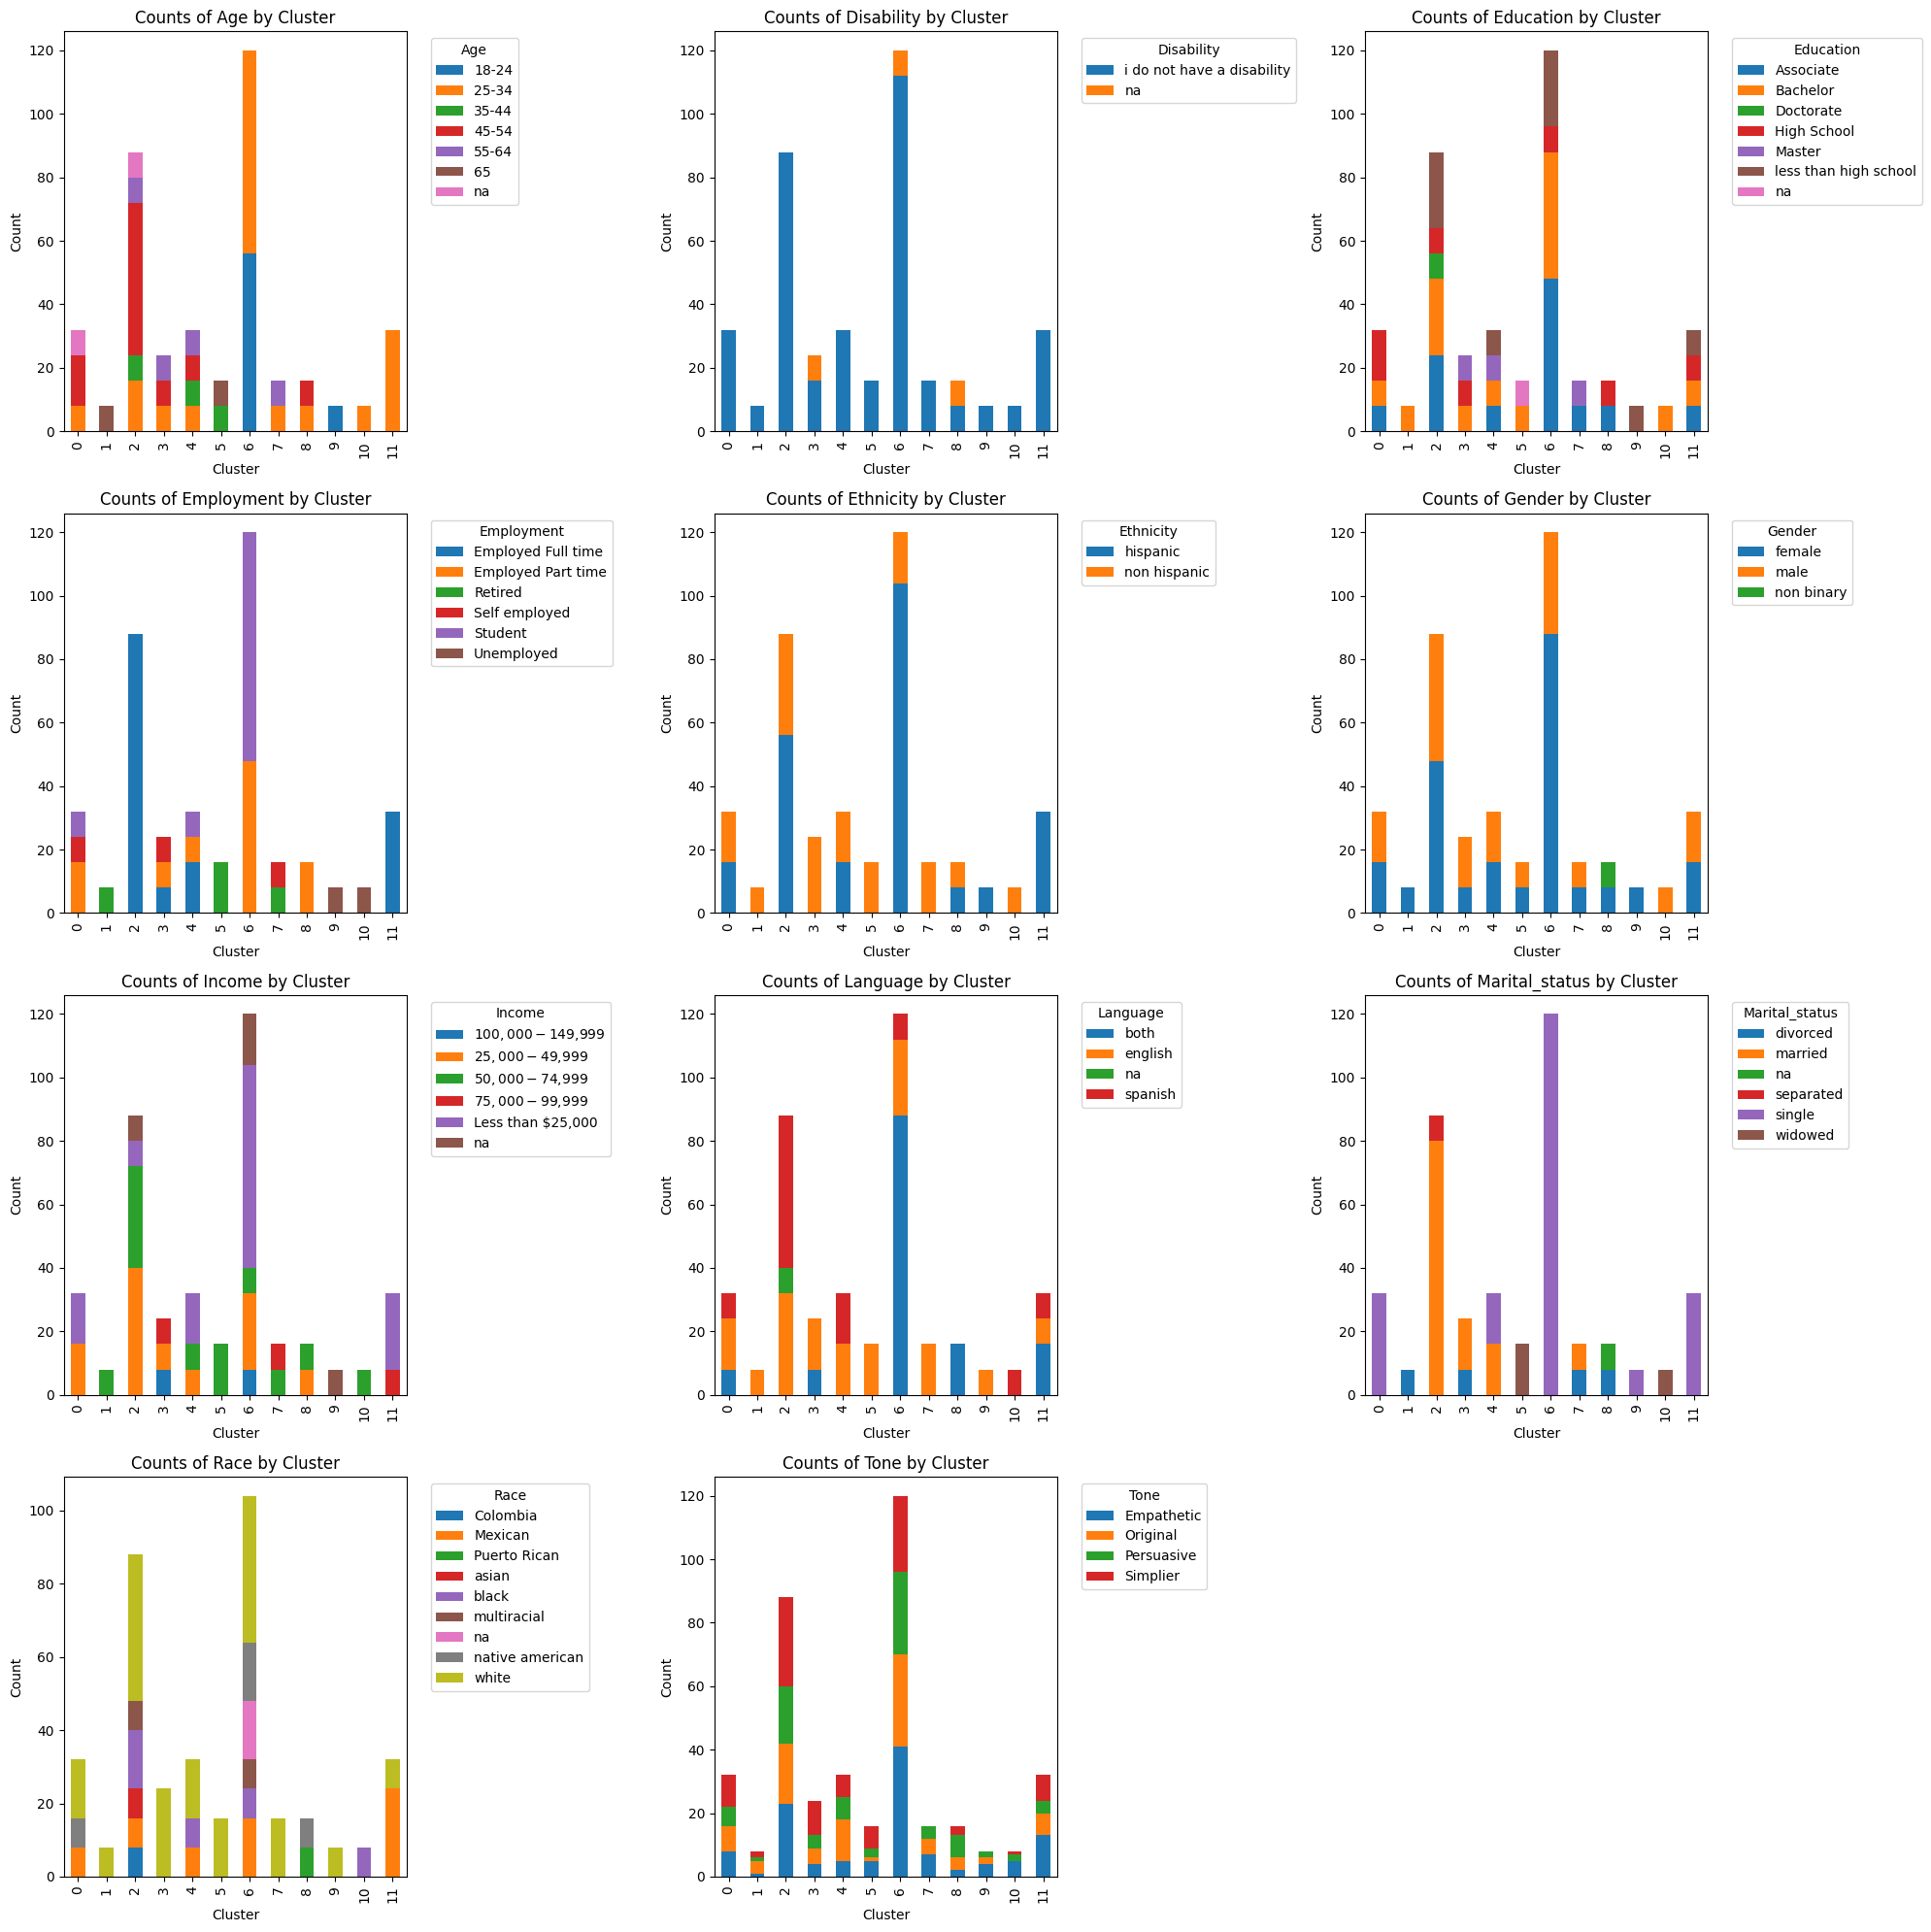

In [301]:
# Number of columns and rows for the subplots grid
n_cols = 3
n_rows = (len(columns_to_plot) + n_cols - 1) // n_cols  # Calculate number of rows needed

# Create a figure and axes for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Generate stacked bar charts for each column
for idx, column in enumerate(columns_to_plot):
    # Aggregate data for the given column
    cluster_option_counts = pca_graphs.groupby(['Cluster', column]).size().unstack(fill_value=0)
    
    # Plotting the stacked bar chart on the corresponding subplot
    ax = cluster_option_counts.plot(kind='bar', stacked=True, ax=axes[idx])
    
    # Add labels and title
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Count')
    ax.set_title(f'Counts of {column.capitalize()} by Cluster')
    ax.legend(title=column.capitalize(), bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Adjust layout for the subplot
    plt.tight_layout()

# Remove any unused axes
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

# Show all plots
plt.show()

## Tabulation
09-07-2024

In [302]:
# Perform the chi-square test
chi2_stat, p_value, dof, expected = stats.chi2_contingency(pd.crosstab(pca_graphs['Cluster'], pca_graphs['tone']))

# Display the results
print(f"Chi-Square Statistic: {chi2_stat}")
print(f"P-Value: {p_value}")


Chi-Square Statistic: 46.759177763399265
P-Value: 0.05676657816400867


## Catboost

In [303]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [304]:
df.head(2)

,age,gender,ethnicity,race,education,marital_status,income,employment,language,disability,states,sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8
0,45-54,female,non hispanic,native american,High School,na,"$25,000 - $49,999",Employed Part time,both,i do not have a disability,indiana,Persuasive,Simplier,Empathetic,Persuasive,Original,Original,Persuasive,Original
1,18-24,male,hispanic,white,High School,single,"Less than $25,000",Employed Part time,english,i do not have a disability,illinois,Original,Simplier,Empathetic,Simplier,Simplier,Original,Original,Persuasive


In [305]:
tones  = df.copy()

In [306]:
tones.drop(['gender', 'ethnicity','race', 'education', 'income','language', 'disability', 'states'], axis=1, inplace=True)

In [307]:
tones.head(2)

,age,marital_status,employment,sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8
0,45-54,na,Employed Part time,Persuasive,Simplier,Empathetic,Persuasive,Original,Original,Persuasive,Original
1,18-24,single,Employed Part time,Original,Simplier,Empathetic,Simplier,Simplier,Original,Original,Persuasive


In [308]:
tones['cluster'] = cluster_labels_pca

In [309]:
df_melted = pd.melt(tones, 
                    id_vars=['age', 'marital_status', 'employment','cluster'], # Columns to keep
                    value_vars=['sample_1', 'sample_2', 'sample_3', 'sample_4', 'sample_5', 'sample_6', 'sample_7', 'sample_8'], # Columns to melt
                    var_name='sample', 
                    value_name='favorite_tone')

In [310]:
df_melted.drop('sample', axis=1, inplace=True)

In [311]:
df_melted.head(2)

,age,marital_status,employment,cluster,favorite_tone
0,45-54,na,Employed Part time,8,Persuasive
1,18-24,single,Employed Part time,6,Original


In [312]:
# Features and target
X = df_melted.drop('favorite_tone', axis=1)
y = df_melted['favorite_tone']

# List of categorical features- Cannot include cluster label as catboost does not support non-categorical values
categorical_features = ['age', 'employment', 'marital_status']

In [313]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [314]:
# Initialize CatBoostClassifier
model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, cat_features=categorical_features, verbose=100)

# Fit the model
model.fit(X_train, y_train)

0:	learn: 1.3769794	total: 80.9ms	remaining: 1m 20s
100:	learn: 0.9625099	total: 7.64s	remaining: 1m 7s
200:	learn: 0.6987483	total: 18.8s	remaining: 1m 14s
300:	learn: 0.5095310	total: 25s	remaining: 58s
400:	learn: 0.3910003	total: 30.7s	remaining: 45.9s
500:	learn: 0.3129388	total: 36.5s	remaining: 36.4s
600:	learn: 0.2453981	total: 42.3s	remaining: 28.1s
700:	learn: 0.1998376	total: 48.4s	remaining: 20.7s
800:	learn: 0.1649982	total: 53.9s	remaining: 13.4s
900:	learn: 0.1405658	total: 59.5s	remaining: 6.54s
999:	learn: 0.1202527	total: 1m 10s	remaining: 0us


In [315]:
predictions = model.predict(X_test)


In [316]:
# Evaluate accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)


Accuracy: 0.2875


In [317]:
# Confusion matrix
cm = confusion_matrix(y_test, predictions)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[ 8  9  4  8]
 [ 1 10  3  2]
 [ 3  6  2  5]
 [ 2  7  7  3]]


**Confusion Matrix Evaluation**  
The confusion matrix shows where the model is making incorrect predictions. 
For the Empathetic tone (row 1), there are 5 correct predictions but 7 incorrect predictions as Original, 4 as Persuasive, and 13 as Simpler.
For Original, the model is performing slightly better with 10 correct predictions, but it still misclassifies instances as other tones.

In [318]:
# Precision, recall, and F1 score
report = classification_report(y_test, predictions)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

  Empathetic       0.57      0.28      0.37        29
    Original       0.31      0.62      0.42        16
  Persuasive       0.12      0.12      0.12        16
    Simplier       0.17      0.16      0.16        19

    accuracy                           0.29        80
   macro avg       0.29      0.30      0.27        80
weighted avg       0.33      0.29      0.28        80



Precision: The proportion of true positives out of all predicted positives. For example, the model has higher precision for the Original tone (0.38) compared to Persuasive (0.12).
Recall: The proportion of true positives out of all actual positives. The recall is relatively better for Original (0.62), indicating the model does a better job at identifying it compared to other tones.
F1-Score: A balance between precision and recall. Original has the best F1-score (0.48), but other classes like Empathetic and Persuasive have much lower scores (0.23 and 0.12, respectively).

## Decision Tree Classifier

In [319]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

ValueError: could not convert string to float: '25-34'

In [262]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.7875
Classification Report:
              precision    recall  f1-score   support

       False       0.82      0.94      0.88        64
        True       0.43      0.19      0.26        16

    accuracy                           0.79        80
   macro avg       0.63      0.56      0.57        80
weighted avg       0.74      0.79      0.75        80

